Modelar o ciclo de cogeração ilustrado abaixo. Permitir que o processo varie de 
0% (desligado) até 100% (completamente ligado).

![Ciclo](img/ciclo.jpeg "Ciclo")

Importando bibliotecas necessárias

In [326]:
from pandas import read_excel, DataFrame
from CoolProp.CoolProp import PropsSI as prop
from CoolProp.CoolProp import State as st
from numpy import arange, absolute, nan
from sympy import symbols
from sympy.solvers.solveset import linsolve

In [327]:
df = read_excel('data.xlsx')
display(df.replace(nan, '-'))

,Temperatura [ºC],Pressão [kPa],Vazão [kg/s],Título [-]
0,485,6495,27.9,-
1,-,900,-,-
2,-,250,-,-
3,51,Saturação,-,-
4,51,Saturação,-,0.0
5,-,250,-,-
6,110,250,-,-
7,-,6495,27.9,-
8,110,250,-,-
9,-,900,-,-


Dados fornecidos

In [328]:
fluido = 'Water'
n_turb, n_pump = 0.85, 0.85
F_processo = 1

Inserindo temperatura de saturação na tabela e convertendo para K

In [329]:
T, c = [], 0

for i in df['Temperatura [ºC]']:
    c = c + 1
    try:
        if i == 'Saturação':
            T.insert(c-1, round(prop('T', 'P', df['Pressão [kPa]'][c-1], 'Q', 0, fluido), 2) )
        else:
            T.insert(c-1, i + 273.15)
    except ValueError or NameError:
        print(f'Sem informações de pressão no estado {c}')

Inserindo pressão de saturação na tabela 

In [330]:
P, c = [], 0
for i in df['Pressão [kPa]']:
    c = c + 1
    try:
        if i == 'Saturação':
            P.insert(c-1, round(prop('P', 'T', T[c-1], 'Q', 0, fluido)/10**3,2) )
        else:
            P.insert(c-1, i)
    except ValueError or NameError:
        print(f'Sem informações de temperatura no estado {c}')

Definindo valores de vazão e titulo a partir da tabela de dados

In [331]:
vazao = df['Vazão [kg/s]']
x = df['Título [-]']

## Definindo estados ##

$$ st: Estado $$

Definindo estados em função da pressão e temperatura com dados fornecidos

$$st: st(P, T)$$

In [332]:
st1 = st(fluido, {'P': P[0], 'T': T[0] })
st7 = st(fluido, {'P': P[6], 'T': T[6] })
st9 = st(fluido, {'P': P[8], 'T': T[8]})


Definindo estados em função da pressão e titulo com dados fornecidos

$$st: st(P, x)$$

In [333]:
st5 = st(fluido, {'P': P[4], 'Q': x[4]})
st11 = st(fluido, {'P': P[10], 'Q': x[10]})
st12 = st(fluido, {'P': P[11], 'Q': x[11]})

Definindo estados a partir da equação de eficiência isentrópica para turbinas

$$ \eta_{turb} = \frac{h_{n-1} - h_{n}}{h_{n-1} - h_{ns}} $$

Estado 2

$$ st_{2s}: st_{2s}(P_{2}, S_{1}) $$
$$ h_{2} = h_{1} - \eta_{turb}(h_{1} - h_{2s}) $$
$$ st_{2}: st_{2}(P_{2}, h_{2}) $$

In [334]:
st2s = st(fluido, {'P': P[1], 'S': st1.s})
h2 = st1.h - n_turb*(st1.h - st2s.h)
st2 = st(fluido, {'P': P[1], 'H': h2})

Estado 3

$$ st_{3s}: st_{3s}(P_{3}, S_{2}) $$
$$ h_{3} = h_{2} - \eta_{turb}(h_{2} - h_{3s}) $$
$$ st_{3}: st_{2}(P_{3}, h_{3}) $$

In [335]:
st3s = st(fluido, {'P': P[2], 'S': st2.s })
h3 = st2.h - n_turb*(st2.h - st3s.h)
st3 = st(fluido, {'P': P[2], 'H': h3 })

Estado 4

$$ st_{4s}: st_{4s}(P_{4}, S_{3}) $$
$$ h_{4} = h_{3} - \eta_{turb}(h_{3} - h_{4s}) $$
$$ st_{4}: st_{4}(P_{4}, h_{4}) $$

In [336]:
st4s = st(fluido, {'P': P[3], 'S': st3.s })
h4 = st3.h - n_turb*(st3.h - st4s.h)
st4 = st(fluido, {'P': P[3], 'H': h4 })

Definindo estados a partir da equação de eficiência isentrópica para bombas

$$ \eta_{pump} = \frac{h_{ns} - h_{n-1}}{h_{n} - h_{n-1}} $$

Estado 6

$$ st_{6s}: st_{6s}(P_{6}, S_{5}) $$
$$ h_{6} = h_{5} + \frac{h_{6s} - h_{5}}{\eta_{pump}} $$
$$ st_{6}: st_{6}(P_{6}, h_{6}) $$

In [337]:
st6s = st(fluido, {'P': P[5], 'S': st5.s })  
h6 = st5.h + (st6s.h - st5.h)/n_pump
st6 = st(fluido, {'P': P[5], 'H': h6 })

Estado 8

$$ st_{8s}: st_{8s}(P_{8}, S_{7}) $$
$$ h_{8} = h_{7} + \frac{h_{8s} - h_{7}}{\eta_{pump}} $$
$$ st_{8}: st_{8}(P_{8}, h_{8}) $$

In [338]:
st8s = st(fluido, {'P': P[7], 'S': st7.s }) 
h8 = st7.h + (st8s.h - st7.h)/n_pump
st8 = st(fluido, {'P': P[7], 'H': h8 })

Estado 10

$$ st_{10s}: st_{10s}(P_{10}, S_{9}) $$
$$ h_{10} = h_{9} + \frac{h_{10s} - h_{9}}{\eta_{pump}} $$
$$ st_{10}: st_{10}(P_{10}, h_{10}) $$

In [339]:
st10s = st(fluido, {'P': P[9], 'S': st9.s}) 
h10 = st9.h + (st10s.h - st9.h)/n_pump
st10 = st(fluido, {'P': P[9], 'H': h10 })

## Obtendo valores de temperatura, pressão, entalpia, entropia e titulo para todos os estados ##

In [340]:
estds = st1, st2, st3, st4, st5, st6, st7, st8, st9, st10, st11, st12

temperatura, pressao, entalpia, entropia, titulo, estados = [], [], [], [], [], arange(1, len(estds)+1, 1)

for i in estds: 
    temperatura.append(i.T - 273.15)
    pressao.append(i.p)
    entalpia.append(i.h)
    entropia.append(i.s)
    if absolute(round(i.Q, 4)) == 1:
        titulo.append('Vap. Sat.')
    elif i.Q == 0:
        titulo.append('Liq. Sat.')
    else:
        titulo.append(i.Q)

## Resolvendo o sistema de equação das vazões ##

Definindo as variaveis como simbólicas

In [341]:
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12 = symbols('m1 m2 m3 m4 m5 m6 m7 m8 m9 m10 m11 m12')
massas = m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12

$$ \frac{dm_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m} = 0 $$
$$ \frac{dE_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n}h_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m}h_{out, m} = 0 $$

$$ m_{1}, m_{2}, m_{3}, m_{4}, m_{5}, m_{6}, m_{7}, m_{8}, m_{9}, m_{10}, m_{11}, m_{12} = \left\{
\begin{array}{lr}
m_{1} - 27,9 = 0\\
m_{8} - 27,9 = 0\\
m_{2} + m_{3} + m_{4} - m_{1} = 0\\
m_{12} + m_{3} + m_{6} - m_{7} = 0\\
m_{2} + m_{10} - m_{11} = 0\\
m_{2}h_{2} + m_{10}h_{10} - m_{11}h_{11} = 0\\
m_{12}h_{12} + m_{3}h_{3} + m_{6}h_{6} - m_{7}h_{7} = 0\\
m_{4} - m_{5} = 0\\
m_{5} - m_{6} = 0\\
m_{11} - m_{12} = 0\\
m_{12} - 6,94F_{processo} = 0\\
m_{9} - m_{10} = 0
\end{array}
\right. $$

In [342]:
eqs_massas = [ m1 - vazao[0], 
               m8 - vazao[7],
               m2 + m3 + m4 - m1,
               m12 + m3 + m6 - m7,
               m2 + m10 - m11,
               m2*st2.h + m10*st10.h - m11*st11.h,
               m12*st12.h + m3*st3.h + m6*st6.h - m7*st7.h,
               m4 - m5,
               m5 - m6,
               m11 - m12,
               m12 - 6.94*F_processo,
               m9 - m10 ]

Criando lista de vazões e arredondando para 2 casas decimais

In [343]:
m = [round(num, 2) for num in list(linsolve(eqs_massas, massas))[0]]

Definindo dicionário de dados dos estados e criando tabela

In [344]:
data_st = {
    'Estado': estados,
    'Temperatura [ºC]': temperatura,
    'Pressão [kPa]': pressao,
    'Entalpia [kJ/kg]': entalpia,
    'Entropia [kJ/kg/K]': entropia,
    'Vazão [kg/s]': m,
    'Titulo [-]': titulo
}

df_st = DataFrame(data_st).style.hide(axis='index').format('{:.2f}', subset=['Temperatura [ºC]', 'Pressão [kPa]', 
                                                                             'Entalpia [kJ/kg]', 'Entropia [kJ/kg/K]', 
                                                                             'Vazão [kg/s]'])

Definindo formato e estilo da tabela

In [345]:
def styler(col):
    if col.name != 'Titulo [-]':
        return [''] * len(col)

    bg_color = col.map({
        'Vap. Sat.': '#8c0a72',
        'Liq. Sat.': '#4523a1',
    }).fillna('') 
    return 'background-color:' + bg_color

## Resultados ##

In [346]:
display(df_st.bar(color='#4523a1', vmin=0, 
                 subset=['Temperatura [ºC]', 'Pressão [kPa]', 'Entalpia [kJ/kg]',
                 'Entropia [kJ/kg/K]', 'Vazão [kg/s]']).apply(styler).format(precision=4, subset=['Titulo [-]']))

                

Estado,Temperatura [ºC],Pressão [kPa],Entalpia [kJ/kg],Entropia [kJ/kg/K],Vazão [kg/s],Titulo [-]
1,485.00,6495.00,3381.20,6.79,27.90,Vap. Sat.
2,243.27,900.00,2932.08,6.95,6.49,Vap. Sat.
3,127.41,250.00,2714.68,7.05,1.34,0.9992
4,51.00,12.98,2333.14,7.26,20.07,0.8908
5,51.00,12.98,213.54,0.72,20.07,Liq. Sat.
6,51.02,250.00,213.82,0.72,20.07,Vap. Sat.
7,110.00,250.00,461.49,1.42,28.35,Vap. Sat.
8,110.75,6495.00,469.21,1.42,27.90,Vap. Sat.
9,110.00,250.00,461.49,1.42,0.45,Vap. Sat.
10,110.08,900.00,462.30,1.42,0.45,Vap. Sat.


## Trabalho, calor e eficiência ##

$$ q_{in} = h_{1} - h_{8} $$
$$ q_{out} = h_{4} - h_{5} $$
$$\eta_{th} = 1 - \frac{q_{out}}{q_{in}}$$

In [353]:
q_in = st1.h - st8.h
q_out = st4.h - st5.h
n_th = 100*( 1 - (q_out/q_in))

$$ \dot{W}_{pump_{1}} = m_{5}(h_{5} - h_{6}) $$
$$ \dot{W}_{pump_{2}} = m_{7}(h_{7} - h_{8}) $$
$$ \dot{W}_{pump_{3}} = m_{9}(h_{9} - h_{10}) $$

In [367]:
W_pump = [round(num, 2) for num in [m[4]*(st5.h - st6.h),
                                    m[6]*(st7.h - st8.h),
                                    m[8]*(st9.h - st10.h)]]

$$ \dot{W}_{pump} = \dot{W}_{pump_{1}} + \dot{W}_{pump_{2}} + \dot{W}_{pump_{3}} $$

In [368]:
W_pump_tot = round(sum(W_pump), 2)

$$ \dot{W}_{turb} = \dot{m}_{1}(h_{1} - h_{2}) + \dot{m}_{2}(h_{2} - h_{3}) + \dot{m}_{3}(h_{3} - h_{4})  $$

In [383]:
W_turb_tot = round(m[0]*(st1.h - st2.h) + m[1]*(st2.h - st3.h) + m[2]*(st3.h - st4.h), 2)

$$ \dot{W}_{liq} = \dot{W}_{pump} + \dot{W}_{turb} $$

In [376]:
W_liq = W_pump_tot + W_turb_tot

$$ \dot{Q}_{cald} = \dot{m}_{8}(h_{1} - h_{8}) $$

In [378]:
Q_cald = m[7]*(st1.h - st8.h)

$$ \eta_{ciclo} = \frac{\dot{W}_{liq}}{\dot{Q}_{cald}} $$

In [384]:
n_ciclo = round(100*W_liq/Q_cald, 2)

Definindo dicionário de dados de trabalho, calor e eficiêcia e criando tabela

In [385]:
data = {
    'q_in [kJ/kg]': [q_in],
    'q_out [kJ/kg]': q_out,
    'η_th [%]': n_th,
    'W_pump_1 [kW]': W_pump[0],
    'W_pump_2 [kW]': W_pump[1],
    'W_pump_3 [kW]': W_pump[2],
    'W_pump [kW]': W_pump_tot,
    'W_turb [kW]': W_turb_tot,
    'η_ciclo [%]': n_ciclo
    
}

df = DataFrame(data).style.hide(axis='index').format(precision=2)

## Resultados ##

In [386]:
display(df)

q_in [kJ/kg],q_out [kJ/kg],η_th [%],W_pump_1 [kW],W_pump_2 [kW],W_pump_3 [kW],W_pump [kW],W_turb [kW],η_ciclo [%]
2911.99,2119.60,27.21,-5.67,-218.72,-0.36,-224.75,14452.53,17.51


## Gráficos ##

In [413]:
def n(v1, v2, v3, v5, v7, v8, v9):

    W_pump_totg = v5*(st5.h - st6.h) + v7*(st7.h - st8.h) + v9*(st9.h - st10.h)
    W_turb_totg = v1*(st1.h - st2.h) + v2*(st2.h - st3.h) + v3*(st3.h - st4.h)
    W_liqg = W_pump_totg + W_turb_totg
    Q_caldg = v8*(st1.h - st8.h)

    return 100*W_liqg/Q_caldg

In [389]:
import matplotlib.pyplot as plt

In [410]:
plt.style.use(['science', 'notebook', 'grid'])

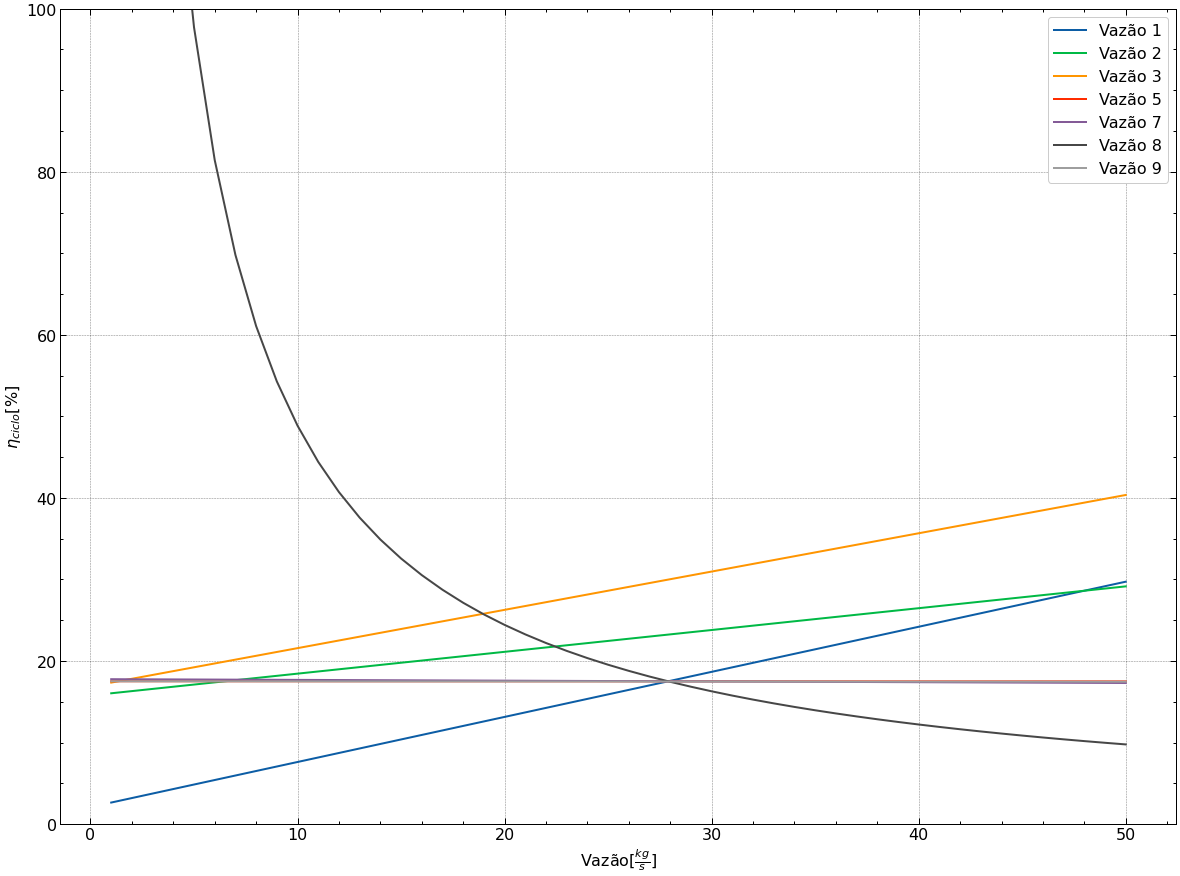

In [422]:

figure = plt.figure(figsize=(20, 15))


plt.plot(arange(1, 50+1, 1), n(v1=arange(1, 50+1, 1), v2=m[1], v3=m[2], v5=m[4], v7=m[6], v8=m[7], v9=m[8]), label='Vazão 1')
plt.plot(arange(1, 50+1, 1), n(v2=arange(1, 50+1, 1), v1=m[0], v3=m[2], v5=m[4], v7=m[6], v8=m[7], v9=m[8]), label='Vazão 2')
plt.plot(arange(1, 50+1, 1), n(v3=arange(1, 50+1, 1), v1=m[0], v2=m[1], v5=m[4], v7=m[6], v8=m[7], v9=m[8]), label='Vazão 3')
plt.plot(arange(1, 50+1, 1), n(v5=arange(1, 50+1, 1), v1=m[0], v2=m[1], v3=m[2], v7=m[6], v8=m[7], v9=m[8]), label='Vazão 5')
plt.plot(arange(1, 50+1, 1), n(v7=arange(1, 50+1, 1), v1=m[0], v2=m[1], v3=m[2], v5=m[4], v8=m[7], v9=m[8]), label='Vazão 7')
plt.plot(arange(1, 50+1, 1), n(v8=arange(1, 50+1, 1), v1=m[0], v2=m[1], v3=m[2], v5=m[4], v7=m[6], v9=m[8]), label='Vazão 8')
plt.plot(arange(1, 50+1, 1), n(v9=arange(1, 50+1, 1), v1=m[0], v2=m[1], v3=m[2], v5=m[4], v7=m[6], v8=m[7]), label='Vazão 9')

plt.ylim(0, 100)
plt.xlabel('Vazão' + r'$[\frac{kg}{s}]$')
plt.ylabel(r'$\eta_{ciclo}$' +'[%]')
plt.legend()
plt.show()


Fazer a modelagem com condensador para que sua temperatura de condensação 
varie conforme a vazão de condensado. Mostrar essa variação.

![Condensador](img/Condensador.jpeg "Condensador")

Desenvolver a análise de primeira lei para o esquema de caldeira abaixo. 
Considerar que este sistema está inserido dentro do ciclo de potência já desenvolvido 
(Fig. 1).


![Caldeira](img/Caldeira.jpeg "Caldeira")